In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/plant-village/PlantVillage',color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=True)

2024-04-06 13:34:00.106409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 13:34:00.106530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 13:34:00.238108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 20638 files belonging to 15 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

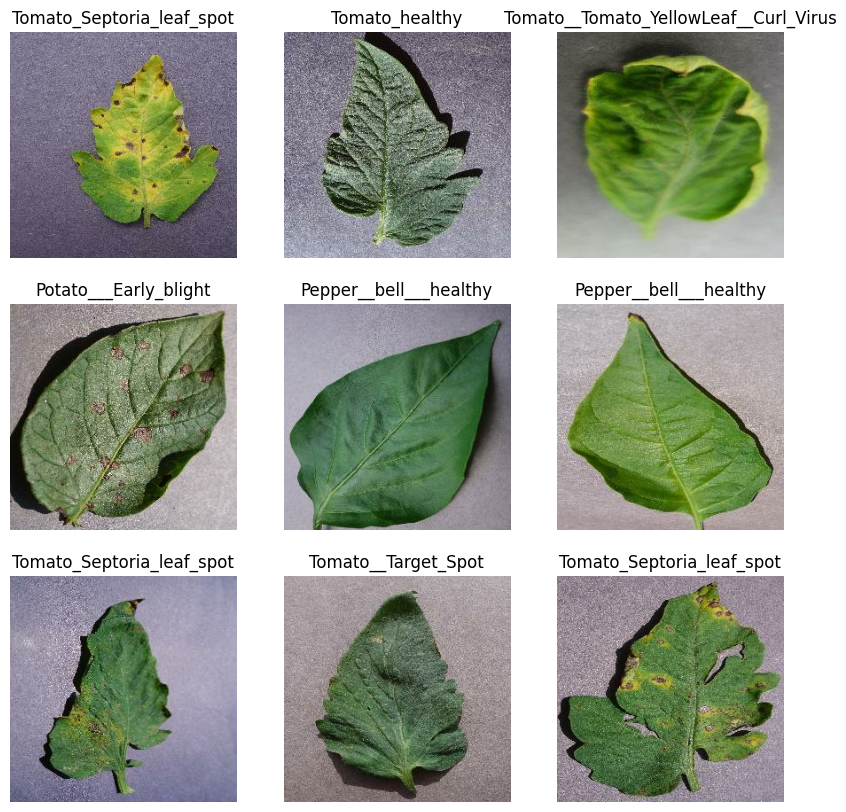

In [5]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        first_image = image_batch[i].numpy().astype('uint8')
        first_label = class_names[label_batch[i].numpy()]
        plt.imshow(first_image)
        plt.title(first_label)
        plt.axis('off')
        

In [13]:
def get_dataset_partitions(ds, shuffle=True,train_split = 0.8, test_split=0.1,val_split=0.1):
    assert train_split + test_split + val_split == 1
    ds_size = len(ds)
    train_size = int(ds_size * train_split)
    test_size = int(ds_size * test_split)
    
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size).skip(test_size)
    
    return train_ds, test_ds, val_ds
    

In [14]:
train_ds, test_ds, val_ds = get_dataset_partitions(dataset)
len(train_ds)

516

In [15]:
train_ds = train_ds.cache().shuffle(1000, seed=12).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000, seed=12).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000, seed=12).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])
    

In [48]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
classes = 15

model = models.Sequential([
    resize_and_rescale,
    augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(64,(2,2),activation='relu'),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.Conv2D(256,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(classes,activation = 'softmax')
])

model.build(input_shape = input_shape)


In [49]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (32, 252, 252, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (32, 84, 84, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (32, 83, 83, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (32, 81, 81, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (32, 40, 40, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (32, 38, 38, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (32, 36, 36, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (32, 18, 18, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (32, 82944)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (32, 128)              │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (32, 15)               │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,067,983 (42.22 MB)

 Trainable params: 11,067,983 (42.22 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model.compile(optimizer ='adam',
             loss = tf.losses.SparseCategoricalCrossentropy(from_logits =False),
             metrics =['accuracy'])

In [51]:
training_history =model.fit(train_ds, epochs = 40, batch_size=BATCH_SIZE,verbose=1, validation_data=val_ds)

Epoch 1/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 54s 99ms/step - accuracy: 0.2397 - loss: 2.2929 - val_accuracy: 0.3782 - val_loss: 1.8349
Epoch 2/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.5828 - loss: 1.2373 - val_accuracy: 0.6617 - val_loss: 0.9539
Epoch 3/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.7214 - loss: 0.8071 - val_accuracy: 0.6978 - val_loss: 0.9502
Epoch 4/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.7897 - loss: 0.6103 - val_accuracy: 0.6554 - val_loss: 1.0997
Epoch 5/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.8306 - loss: 0.5001 - val_accuracy: 0.7324 - val_loss: 0.8771
Epoch 6/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 51s 98ms/step - accuracy: 0.8644 - loss: 0.3959 - val_accuracy: 0.8537 - val_loss: 0.4181
Epoch 7/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 51s 98ms/step - accuracy: 0.8824 - loss: 0.3450 - val_accuracy: 0.8109 - val_loss: 0.5636
Epoch 8/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.8902 - loss: 0.3199 - 

In [52]:
model.evaluate(test_ds)

64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9464 - loss: 0.1622


[0.16454963386058807, 0.95068359375]

In [53]:
training_history.params

{'verbose': 1, 'epochs': 40, 'steps': 516}

In [55]:
training_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [56]:
acc = training_history.history['accuracy']
loss = training_history.history['loss']
val_acc = training_history.history['val_accuracy']
val_loss = training_history.history['val_loss']

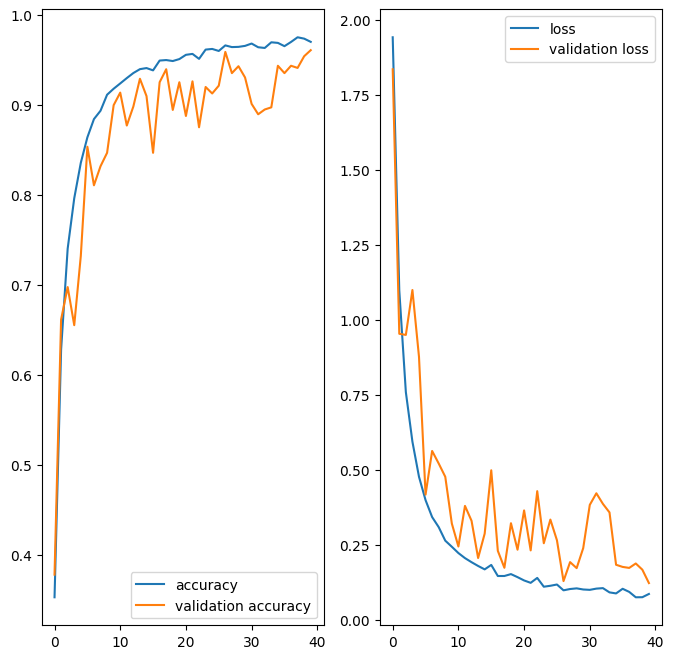

In [67]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(40),acc, label = 'accuracy')
plt.plot(range(40),val_acc, label = 'validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(40),loss, label = 'loss')
plt.plot(range(40),val_loss, label = 'validation loss')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


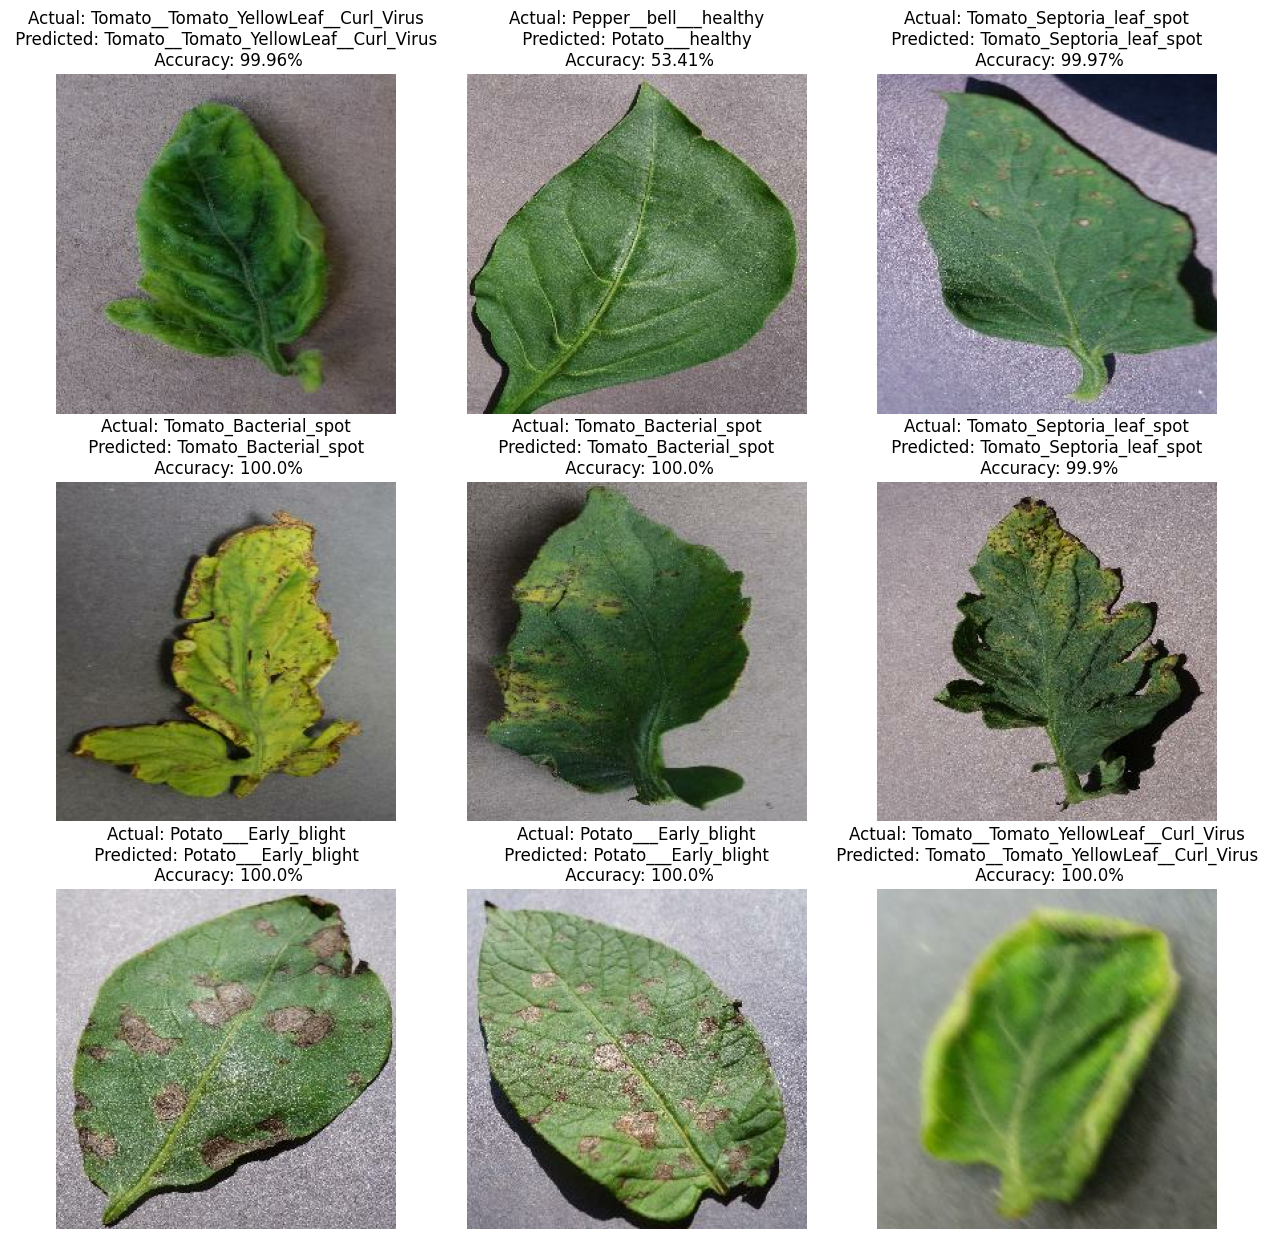

In [75]:
import numpy as np
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        first_image_to_predict = image_batch[i].numpy().astype('uint8')
        first_label_to_predict = class_names[label_batch[i].numpy()]
        
        predictions = model.predict(image_batch)
        prediction =class_names[np.argmax(predictions[i])]
        accuracy = round(100*np.max(predictions[i]),2)
        
        plt.imshow(first_image_to_predict)
        plt.title(f'Actual: {first_label_to_predict}\n Predicted: {prediction} \n Accuracy: {accuracy}%' )
        plt.axis('off')
        

In [88]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    prediction =class_names[np.argmax(predictions[0])]
    accuracy = round(100*(np.max(predictions[0])),2)
    
    return prediction, accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


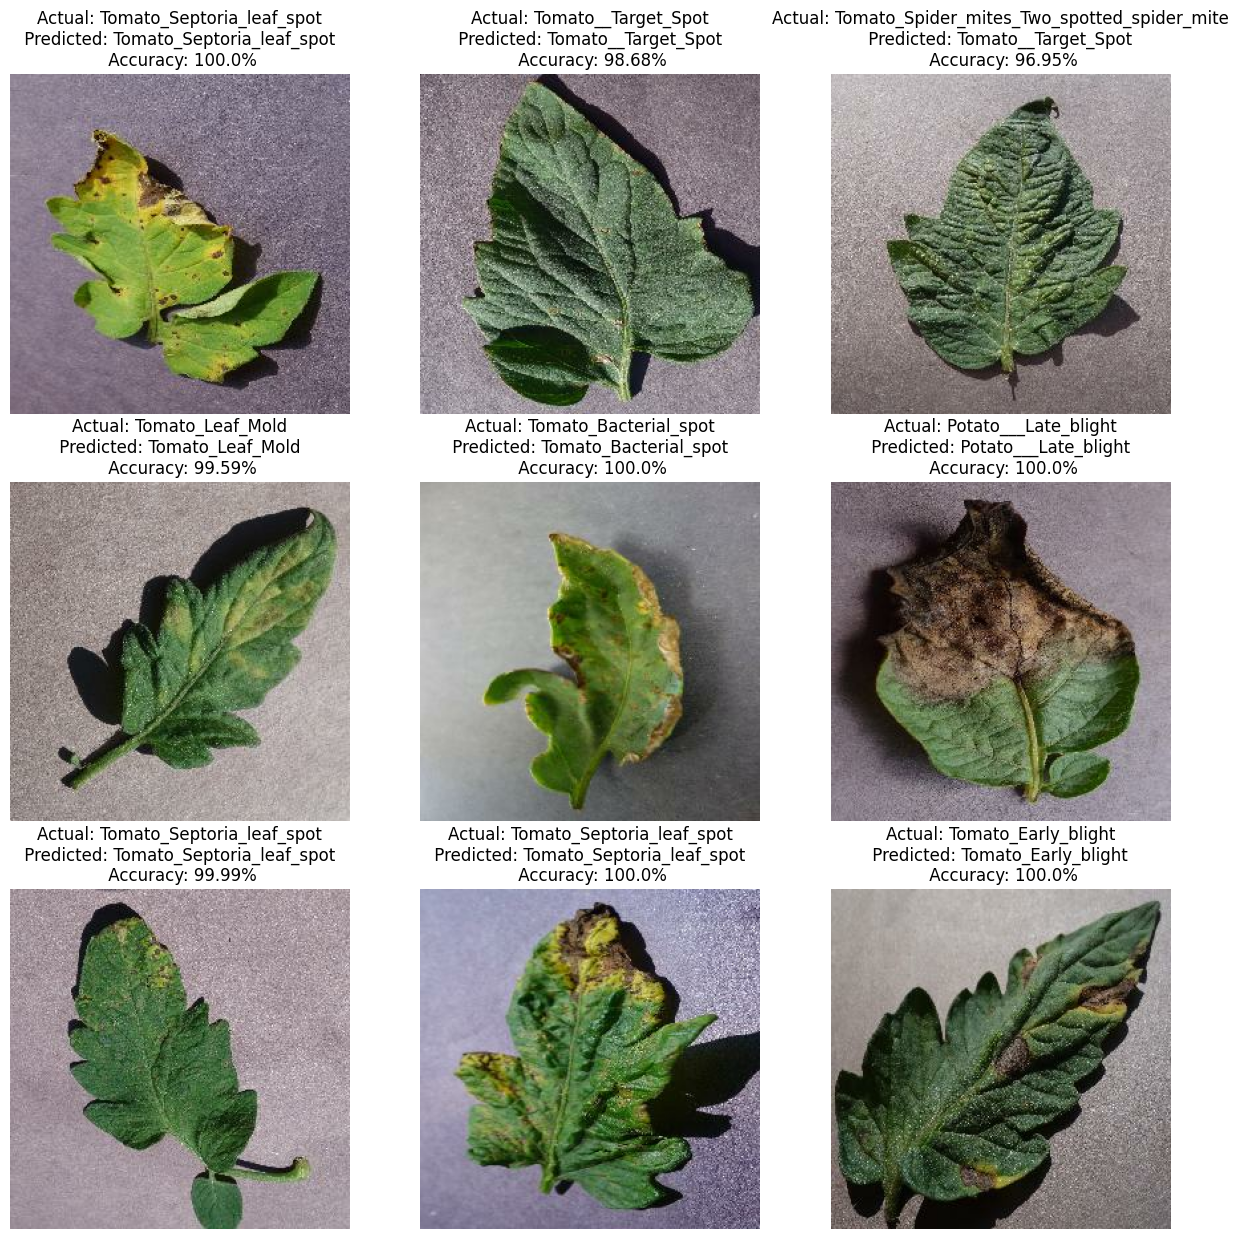

In [89]:
plt.figure(figsize=(15,15))
for images,label in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        first_image_to_predict = images[i].numpy().astype('uint8')
        first_label_to_predict = class_names[label[i].numpy()]
        
        prediction, accuracy = predict(model,images[i].numpy())
        
        plt.imshow(first_image_to_predict)
        plt.title(f'Actual: {first_label_to_predict}\n Predicted: {prediction} \n Accuracy: {accuracy}%' )
        plt.axis('off')

In [126]:
model_version = 1


In [127]:
model.save("model.keras")